# Investigating the word model
### imports

In [1]:
from blocks.model import Model
from conllutil import CoNLLData
from itertools import chain
%matplotlib inline
import matplotlib.pyplot as plt
from network import *
from numpy import array, hstack, load, save, vstack, zeros
from os import path
from pandas import factorize
from random import randint
from scipy.stats import pearsonr
from stoogeplot import hinton_diagram
from theano import function
from theano.tensor.sharedvar import SharedVariable
from theano.tensor import matrix, TensorType
from util import StateComputer, simple_mark_dependency

### constants

In [16]:
ALPHA = .05
MODEL_FILE = './models/hdt/hdt-ncs-eos-np-35-7-1/models/seqgen_lstm_512_512.pkl'
IX_2_TOK_FILE = './data/hdt-ncs-eos-np-35-7-1_ix2tok.npy'
HDT_DIR = '../datasets/hdt/hamburg-dependency-treebank-conll/'
NP_FOLDER = './data/np'

### Build model

In [17]:
ix2tok = load(IX_2_TOK_FILE).item()
nt = Network(NetworkType.LSTM, input_dim=len(ix2tok), hidden_dims=[512,512])
nt.set_parameters(MODEL_FILE)

### Building generator

In [18]:
model = Model(nt.generator.generate(n_steps=nt.x.shape[0], batch_size=nt.x.shape[1]))
param_dict = model.get_parameter_dict()
init_state_0 = param_dict['/sequencegenerator/with_fake_attention/transition/layer#0.initial_state']
init_state_1 = param_dict['/sequencegenerator/with_fake_attention/transition/layer#1.initial_state']
#init_state_2 = param_dict['/sequencegenerator/with_fake_attention/transition/layer#2.initial_state']
init_cells_0 = param_dict['/sequencegenerator/with_fake_attention/transition/layer#0.initial_cells']
init_cells_1 = param_dict['/sequencegenerator/with_fake_attention/transition/layer#1.initial_cells']
#init_cells_2 = param_dict['/sequencegenerator/with_fake_attention/transition/layer#2.initial_cells']
reset_values = {
    0: (init_state_0.get_value(), init_cells_0.get_value()),
    1: (init_state_1.get_value(), init_cells_1.get_value()),
    #2: (init_state_2.get_value(), init_cells_2.get_value())
}
gen_func = model.get_theano_function(allow_input_downcast=True)

In [19]:
tok2ix = {v: k for k, v in ix2tok.items()}
sc = StateComputer(nt.cost_model, tok2ix)

### Generation procedure

In [20]:
def reset_generator():
    init_state_0 = reset_values[0][0]
    init_cells_0 = reset_values[0][1]
    init_state_1 = reset_values[1][0]
    init_cells_1 = reset_values[1][1]
    #init_state_2 = reset_values[2][0]
    #init_cells_2 = reset_values[2][1]
    
def init_zero():
    # note sure this is always a good idea
    d = init_state_0.get_value().shape[0]
    dt = 'float32'
    init_state_0.set_value(zeros(d, dtype=dt))
    init_cells_0.set_value(zeros(d, dtype=dt))
    init_state_1.set_value(zeros(d, dtype=dt))
    init_cells_1.set_value(zeros(d, dtype=dt))
    #init_state_2.set_value(zeros(d, dtype=dt))
    #init_cells_2.set_value(zeros(d, dtype=dt))
    
def generate_sequence(start, reset_func):
    
    seq = [start]
    ix = array([[tok2ix[start]]])
    while not seq[-1] == '<EOS>':
        #state_0, cells_0, state_1, cells_1, state_2, cells_2, ix, costs = gen_func(ix)
        state_0, cells_0, state_1, cells_1, ix, costs = gen_func(ix)
        init_state_0.set_value(state_0[0][0])
        init_cells_0.set_value(cells_0[0][0])
        init_state_1.set_value(state_1[0][0])
        init_cells_1.set_value(cells_1[0][0])
        #init_state_2.set_value(state_2[0][0])
        #init_cells_2.set_value(cells_2[0][0])
        seq.append(ix2tok[ix[0][0]])
    
    reset_func()
    
    return ' '.join(seq[:-1])


In [27]:
# you can use this function for generating just for fun or checking the model, if you like,
# you just need to provide a start word

print(generate_sequence('den', reset_generator))  # good results 500 - 1000

den oder filter


# Check correlations with POS
## Step 1: Read all sentences from PART_A and store activations

__comment:__  Only part A is used, since this one's annotations are handmade and checked.

First all sentences are loaded as lists of word indices; For alignment with the plots we also compute the activations for the `<EOS>`-word, because an additional word then allows us to access the activation triggered by the new last-but-one word.

In [7]:
eos_ix = tok2ix['<EOS>']
cd = CoNLLData(HDT_DIR, ['part_A.conll'], tok2ix, word_transform=str.lower, lazy_loading=True, min_len=7, max_len=35)
sentences_ix = [[tok2ix[seq[i]] for i in range(len(seq))] + [eos_ix] for seq in cd.wordsequences()]

In [11]:
# maximal number of sentences to calculate for
upper_limit = 2000

cell_name = sc.state_var_names[2]
# for testing purposes only read two sequences, try again later with more
activations = sc.read_single_sequence(sentences_ix[0])[cell_name][1:,:]
# this will take FOREVER
for ix_seq in sentences_ix[1:upper_limit]:
    activations = vstack((activations, sc.read_single_sequence(ix_seq)[cell_name][1:,:]))

### Correlate for each pos tag

Here correlations are checked for ART, NN, and ADJA, all marked and computed separately. ADJA means "attributive adjective" and refers to prenominal occuring adjectives. This checking was done to actually prepare later checking of the `DET`- and maybe also the `ATTR` relation, which allow to do research on the relation of two words and how it is represented in the network.

In [12]:
# to keep computation low, we just do in for a small set, there is no time left to check it anyway
# tagset = set(chain(*cd.possequences()))
tagset = {'ART', 'ADJA', 'NN'}
pos_corrs = {}
for tag in tagset:
    crlist = []
    tag_seq = [1 if ptag == tag else 0 for ptag in chain(*cd.possequences()[:upper_limit])]
    for activation in activations.transpose():       
        """
        NOTE: activation is the concatenated activation of a particular cell of all sentences
        Otherwise there wouldn't be enough data points for sentences with 7 <= length <= 35
        ---
        This is not the cleanest imaginable approach, since the activations between sequences
        are not related, but it still might provide some insights
        """
        pc = pearsonr(activation, tag_seq)
        crlist.append(pc[0] if pc[1] < ALPHA else 0.0)
    pos_corrs[tag] = array(crlist)

### Extract 10 highest correlations for POS-Tags ART, NN, ADJA, since they might be relevant for the DET relation

In [13]:
top_corr_ix = {}
for tag in tagset:
    top_corr_ix[tag] = abs(pos_corrs[tag]).argsort()

### Let's plot that for some tokens, 10 strongest cells only

__NOTE:__ The plots are aligned this time, i. e. a displayed activation occured after reading the word given in the label below!

#### ART

A nice effect can be observed: Some neurons get high activations on apearance of ART, but this activations drops __immediately__ when the (in most of the cases) governing NN appears.

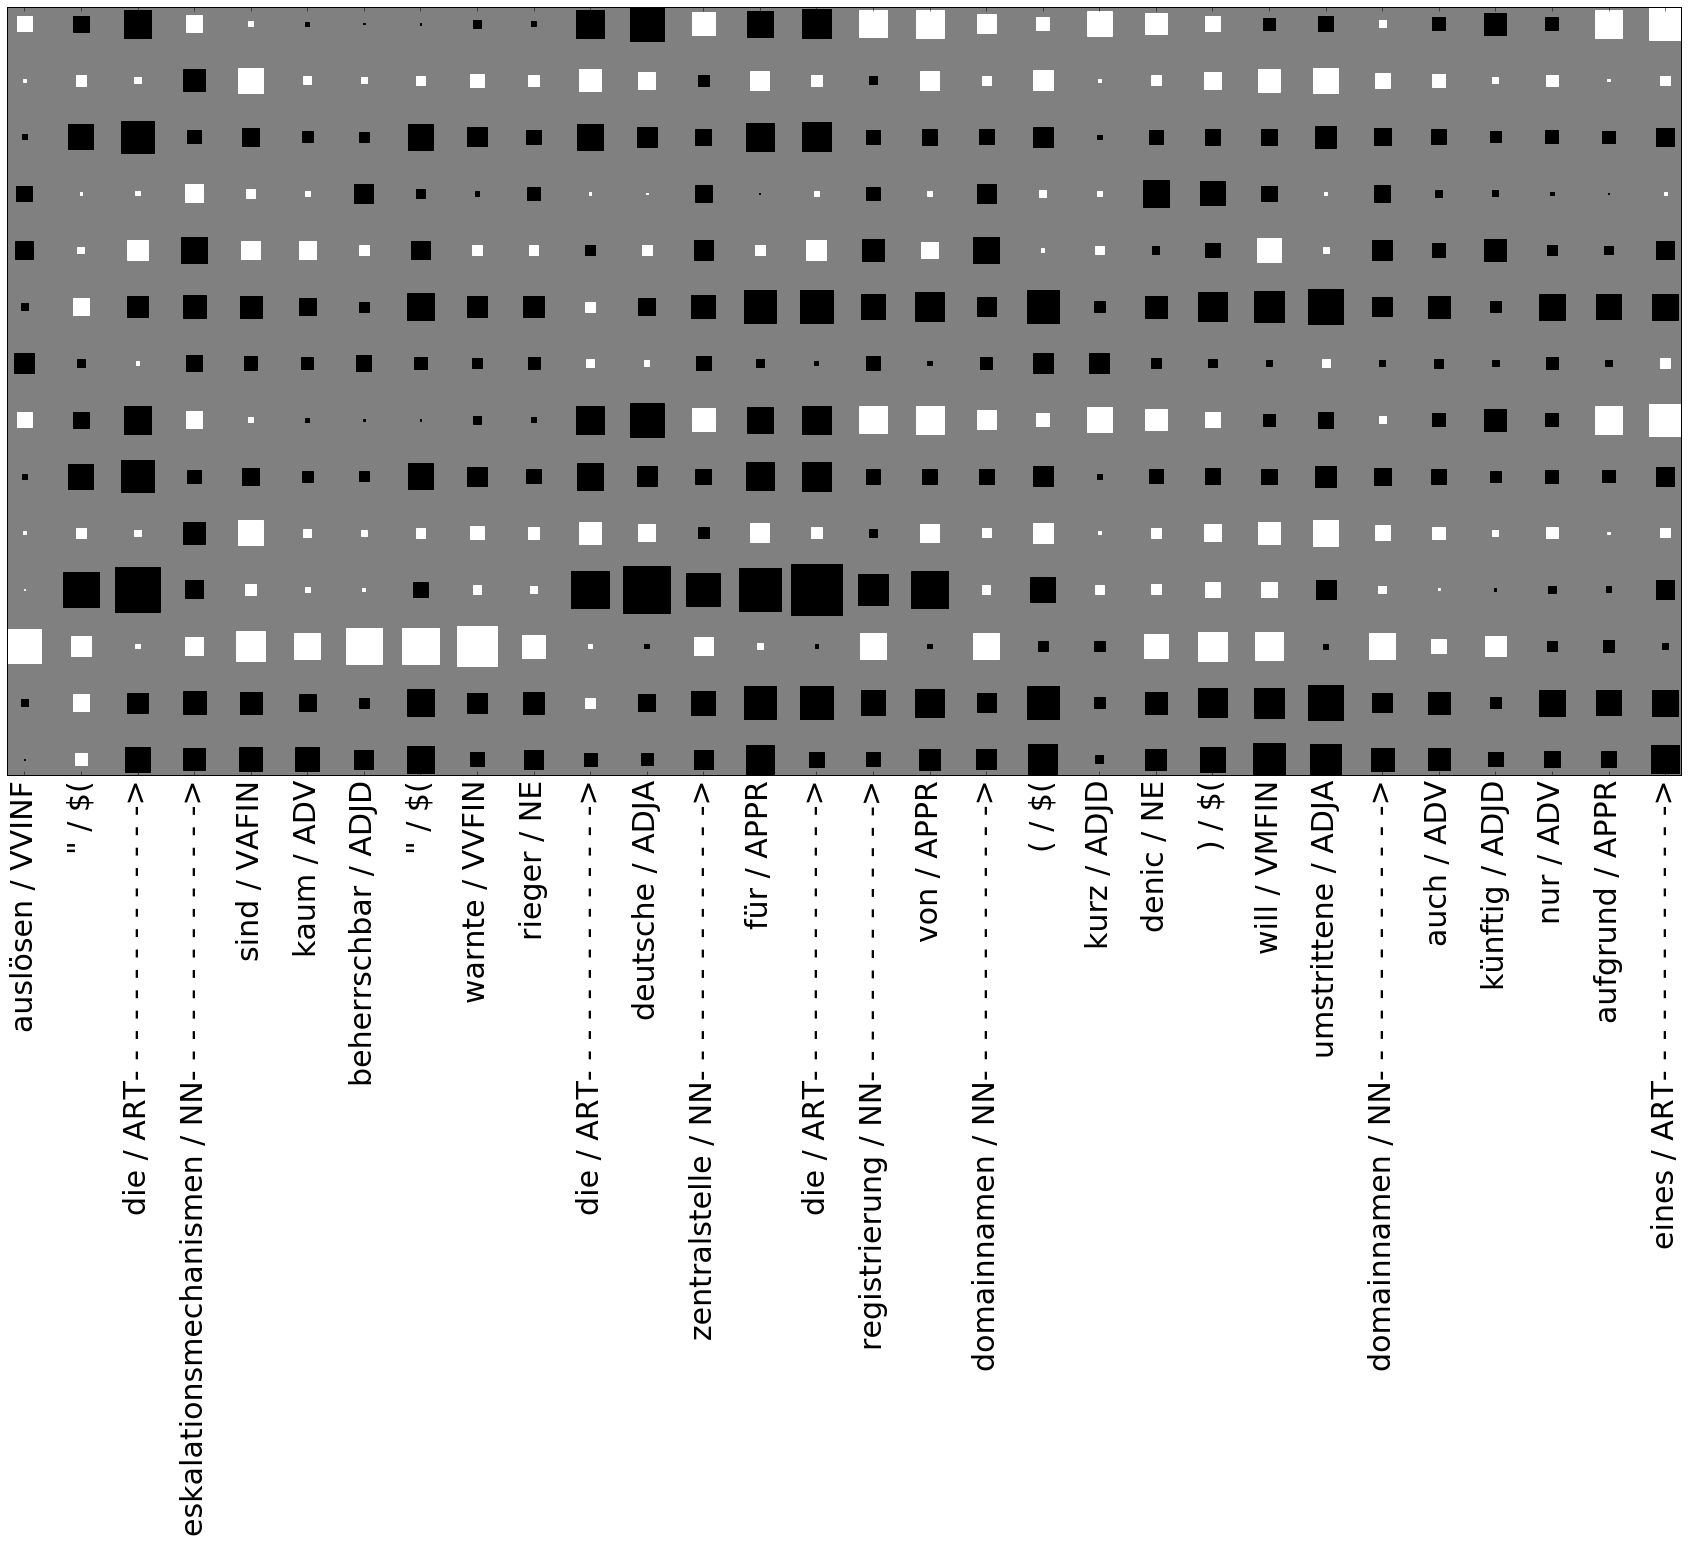

In [20]:
# these are word indices in the chained list, i. e. a list containing all words of the corpus as a sequence
start = 300
end = 330

show_all = True

f = plt.figure(figsize=(30, 50))
xlabels = [tpl[1]+' / '+tpl[4] + ('- - - - - - - - - - - - - ->' if tpl[4] == 'NN' or tpl[4] == 'ART' else '') for tpl in list(chain(*cd.sequences()[:upper_limit]))[start:end]] if show_all else [(tpl[1]+' / '+tpl[4]) if tpl[4] == 'NN' or tpl[4] == 'ART' else '' for tpl in list(chain(*cd.sequences()[:upper_limit])[start:end])]
indices = hstack((top_corr_ix['ART'][-7:], top_corr_ix['NN'][-7:]))
x = activations[start:end, indices]
ax = plt.gca()
h = hinton_diagram(x, ax=ax)
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=90, fontdict={'fontsize': 30})
f.subplots_adjust(bottom=.2)


#### ADJA

For ADJA there has to be done more checking, but they seem to be memorized like quotation marks: They switch neurons on and off when appearing; but that is just a weak assumption. More interesting to investigate would be: How do they interact with ART- and NN-activations.

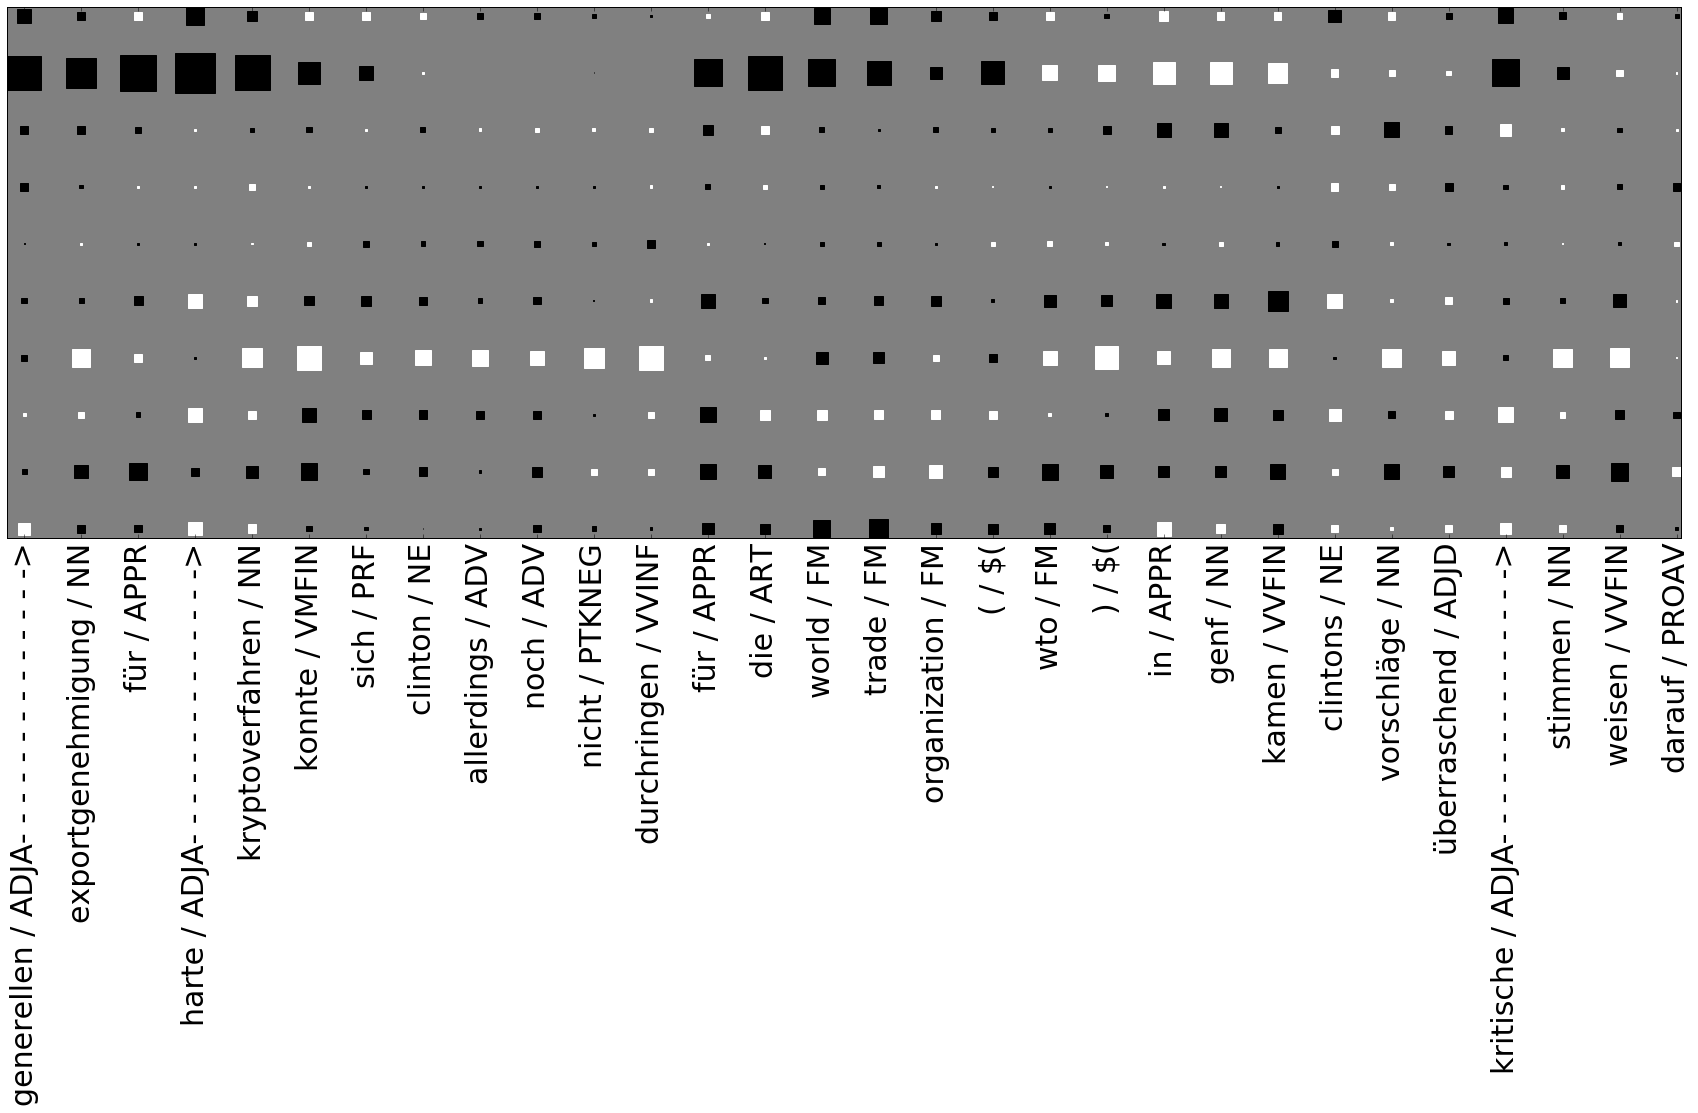

In [36]:
start = 34680
end = 34710

show_all = True

f = plt.figure(figsize=(30, 50))
xlabels = [tpl[1]+' / '+tpl[4] + ('- - - - - - - - - - - - - ->' if tpl[4] == 'ADJA' else '') for tpl in list(chain(*cd.sequences()[:upper_limit]))[start:end]] if show_all else [(tpl[1]+' / '+tpl[4]) if tpl[4] == 'ADJA' else '' for tpl in list(chain(*cd.sequences()[:upper_limit])[start:end])]
x = activations[start:end,top_corr_ix['ADJA'][-10:]]
ax = plt.gca()
h = hinton_diagram(x, ax=ax)
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=90, fontdict={'fontsize': 30})
f.subplots_adjust(bottom=.2)

## Correlation values:
ART, ADJA and then NN

Correlations do not seem to be very high, but we are only looking at 2k sentences with a weak model.

In [19]:
for tag in tagset:
    print(tag, *pos_corrs[tag][top_corr_ix[tag][-10:]], sep='\n ')

NN
 0.242266887958
 0.244945677541
 0.248455837534
 -0.251380766066
 0.27205360125
 -0.2775074831
 -0.290461783888
 0.302345425012
 -0.305190912431
 0.349008519735
ADJA
 0.226849307484
 0.228985965593
 0.229379858024
 -0.237664566232
 0.238519655695
 -0.247234802198
 -0.25008356116
 0.259059910489
 -0.260582378394
 -0.287534710924
ART
 -0.266822667487
 -0.269268383539
 0.270576002918
 -0.272046890942
 -0.292610564159
 -0.315776176215
 -0.31962074559
 0.337086145333
 -0.358808812018
 -0.371809633249


## A   *v e r y*   short trip to dependencies

For the determiner label we have the chance to analyze __common__ activation correlations, instead of only for the single node (ART or NN).

In [35]:
from numpy import where

pseq = array(list(chain(*cd.possequences()[:upper_limit])))
where(pseq == 'ADJA')[0][200:300]

array([3087, 3123, 3136, 3141, 3142, 3143, 3150, 3214, 3225, 3249, 3270,
       3294, 3299, 3329, 3342, 3361, 3383, 3386, 3409, 3421, 3431, 3452,
       3457, 3465, 3479, 3486, 3489, 3514, 3520, 3535, 3549, 3557, 3564,
       3579, 3583, 3590, 3607, 3619, 3627, 3671, 3683, 3689, 3697, 3729,
       3733, 3751, 3770, 3771, 3775, 3785, 3788, 3795, 3810, 3817, 3824,
       3838, 3845, 3875, 3883, 3903, 3938, 3944, 3969, 3987, 4003, 4009,
       4078, 4082, 4096, 4103, 4119, 4149, 4193, 4206, 4250, 4254, 4271,
       4318, 4322, 4396, 4418, 4422, 4439, 4465, 4492, 4518, 4529, 4580,
       4595, 4617, 4626, 4635, 4655, 4684, 4719, 4730, 4756, 4760, 4765,
       4769])